In [1]:
import sys
sys.path.insert(0,'..')
import astropy
import astropy.units as u 
import astropy.constants as const

import os
import datetime

import numpy as np
import math
import scipy.optimize
import scipy.constants

import jabble.dataset
import jabble.loss
import jabble.model
import jabble.physics
import jabble.quickplay

import matplotlib.pyplot as plt

from collections import namedtuple
# from jaxopt import GaussNewton
import jax.numpy as jnp
import jax

jax.config.update("jax_enable_x64", True)

<h1>01 - Measure RVs from fake data using Wobble</h1>
In this notebook, we use wobble models to both create artificial data with given RVs. Then extract those RVs using the wobble Irwin-Hall model.

In [2]:
today = datetime.date.today()
out_dir = os.path.join('/scratch/mdd423/wobble_jax','out',today.strftime("%y-%m-%d"))
os.makedirs(out_dir,exist_ok=True)

In [3]:
def gaussian(x, mu, sigma):
    return np.exp(
        -((x - mu) ** 2) / (2 * sigma**2)
    )  # / (2 * sigma * np.sqrt(2 * np.pi))(1/np.sqrt(2 * np.pi *sigma**2)) * 

In [4]:
def create_dataset(x_grid, shifts, line, depth, snr, resolution):
    epoches = len(shifts)
    flux = np.ones((epoches, *x_grid.shape), dtype=np.float64)

    sigma = jabble.physics.delta_x(resolution)
    for i in range(epoches):
        flux[i, :] -= depth * gaussian(x_grid,line + shifts[i],sigma)

    # add noise
    flux += np.random.normal(0.0, np.abs(flux / snr),size=flux.shape)

    ferr = flux / snr
    yerr = ferr / flux
    mask = np.zeros(flux.shape)
    dataset = jabble.dataset.Data.from_lists(
        x_grid[None, :].repeat(epoches, 0), np.log(flux), 1/yerr**2, mask
    )
    return dataset

<h2>Fake Data Parameters</h2>
Here we define the parameters of the data, we will generate. This includes the resolution of the spectrograph, signal to noise ratio, number of epochs, and number of telluric and stellar spectral lines.

In [6]:
resolution = 120_000
snr = 500
epoches = 100

dx = jabble.physics.delta_x(2 * resolution)
lmin = 4654
lmax = 4657
x_grid = np.linspace(np.log(lmin), np.log(lmax), int((np.log(lmax) - np.log(lmin))/dx), \
                     dtype="float64")

wave_grid = np.exp(x_grid) * u.Angstrom

guess_vel = np.linspace(-60, 60, epoches) * u.km / u.s
extra_vel = np.linspace(-30, 30, epoches) * u.m / u.s
velocities = guess_vel + extra_vel
shifts = jabble.physics.shifts(velocities.to(u.m/u.s).value)

line = np.mean(x_grid)
depth = 0.7
dataset = create_dataset(x_grid, shifts, line, depth, snr, resolution)
print(x_grid.shape)

(154,)


Now generate multiple datasets with these parameters.

Let's take a look at a couple of epochs, before we go on modeling it.

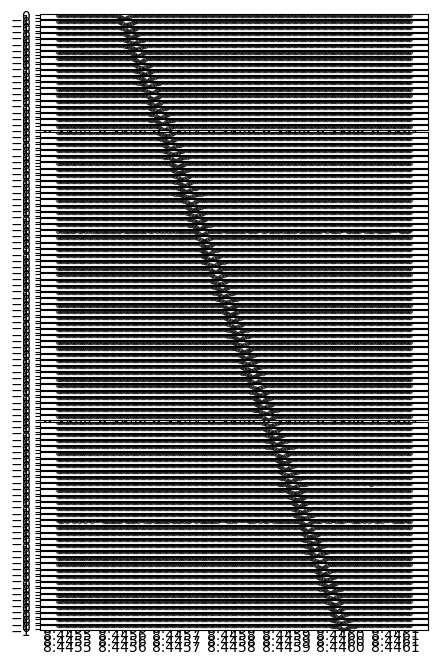

In [7]:
plt_epoches = np.arange(0,epoches,dtype=int)
fig, axes = plt.subplots(len(plt_epoches), figsize=(5, 8))
for i, plt_epoch in enumerate(plt_epoches):
    axes[i].errorbar(
        dataset[plt_epoch].xs[:],
        dataset[plt_epoch].ys[:],
        1/np.sqrt(dataset[plt_epoch].yivar[:]),
        fmt=".k",
        elinewidth=2.2,
        zorder=1,
        alpha=0.5,
        ms=6,
    )

    #     axes[ele].set_xlim(xpmin-shifts[ele],xpmax-shifts[ele])
    # axes[i].set_ylim(-2, 0.2)
plt.show()

In [8]:
cpus = jax.devices("cpu")
# gpus = jax.devices("gpu")

init_vels = guess_vel
init_shifts = jabble.physics.shifts(init_vels.to(u.m/u.s).value)

In [9]:
def get_model(dataset,resolution,p_val,vel_padding,init_rvs):
         
    dx = jabble.physics.delta_x(2 * resolution)
    x_grid = jnp.arange(np.min(np.concatenate(dataset.xs)), np.max(np.concatenate(dataset.xs)), step=dx, dtype="float64")
    
    model_grid = jabble.model.create_x_grid(
        x_grid, vel_padding.to(u.m/u.s).value, 2 * resolution
    )  
    init_shifts = jabble.physics.shifts(init_rvs.to(u.m/u.s).value)
    model = jabble.model.CompositeModel(
        [
            jabble.model.ShiftingModel(init_shifts),#ShiftingModel(init_shifts),#
            jabble.model.FullCardinalSplineMixture(model_grid, p_val),
        ]
    ) 
    # + jabble.model.CompositeModel(
    #     [
    #         jabble.model.ShiftingModel(init_shifts),#ShiftingModel(init_shifts),#
    #         jabble.model.CardinalSplineMixture(model_grid, p_val),
    #     ]
    # )

    # model.to_device(device)

    # model.fit(2)
    # print(type(model.get_parameters()),model.get_parameters().devices())
    return model

In [10]:
def train_cycle(model, dataset, loss, device_store, device_op, batch_size):
    options = {"maxiter": 512,\
               "factr": 1.0,\
              }

    # Fit Stellar & Telluric Template
    model.fix()
    model.fit(1)
    model.display()
    
    res1 = model.optimize(loss, dataset, device_store, device_op, batch_size, options=options)#model.optimize(loss, dataset)
    print(res1)
    
    # Fit RV
    model.fix()
    model.fit(0)
    res1 = model.optimize(loss, dataset, device_store, device_op, batch_size, options=options)
    print(res1)

    # Fit Everything
    model.fix()
    model.fit(0)
    model.fit(1)
    # model.fit(2,1)

    res1 = model.optimize(loss, dataset, device_store, device_op, batch_size, options=options)#model.optimize(loss, dataset)
    print(res1)

    return model

In [11]:
device_store = cpus[0]
device_op = cpus[0]
batch_size = 5000
p_val = 3
vel_padding = 100 * u.m/u.s

data_name = os.path.join(out_dir,'simple_fake','simple_fake_data_norm.pkl')
model_name = os.path.join(out_dir,'simple_fake','simple_fake_model_norm.pkl')

model =  get_model(dataset,resolution,p_val,vel_padding,guess_vel)

loss = jabble.loss.ChiSquare()

model.display()

model = train_cycle(model, dataset, loss, device_store, device_op, batch_size)

rv_model = model
for ii in [0]:
    rv_model = rv_model[ii]
rv_model.display()

# jabble.quickplay.save(model,model_name,data_name,data=dataset,shifts=model[0].p,\
#                       device=device_op,loss=loss,rv_ind=[0])

-CompositeModel----------------------------------------------------0
  0-ShiftingModel--------------------------------------------------0
  1-FullCardinalSplineMixture--------------------------------------0
-CompositeModel--------------------------------------------------155
  0-ShiftingModel--------------------------------------------------0
  1-FullCardinalSplineMixture------------------------------------155
{'grad': array([ 2.58918483e-03, -5.29022822e-03,  7.77514899e-03, -9.70241703e-03,
        1.05485229e-02, -1.02708134e-02,  9.36536506e-03, -8.16139176e-03,
        6.65330485e-03, -5.01958388e-03,  3.67818826e-03, -2.78370410e-03,
        2.15306508e-03, -1.72861878e-03,  1.71314263e-03, -2.17799201e-03,
        2.84662174e-03, -3.39897671e-03,  3.74190965e-03, -3.91628142e-03,
        3.93173778e-03, -3.82957615e-03,  3.79706036e-03, -3.87042907e-03,
        4.01304049e-03, -3.96443225e-03,  3.43183629e-03, -3.17387453e-03,
        1.50232232e-03, -2.06314538e-03, -9.41068904

In [12]:
def make_subplot(axes,model,dataset,plt_epoch,device,lrange):

    model.fix()
    data, meta, keys = dataset.blockify(device,return_keys=True)
    
    datarow = jabble.loss.dict_ele(data,plt_epoch,device)
    metarow = jabble.loss.dict_ele(meta,plt_epoch,device)
    # fig.suptitle("Order {}".format(keys["orders"][meta["orders"][plt_epoch]]))
    # axes[0,ii].title.set_text('Date: {}'.format(keys["times"][meta["times"][plt_epoch]]))

    # print(metarow['index'],plt_epoch)
    
    xplot = np.linspace(np.log(lrange.min()),np.log(lrange.max()),\
                        dataset.xs[plt_epoch].shape[0]*10)

    yplot_norm_tot  = model([],xplot,metarow)
    # for epoch in np.where(indices):
    yhat = model([],dataset.xs[plt_epoch][~datarow["mask"]],metarow)

    axes[0].set_xlim(xplot.min(),xplot.max())

    
    # Data
    # print(datarow)
    axes[0].errorbar(datarow["xs"][~datarow["mask"]],datarow["ys"][~datarow["mask"]],\
                     yerr=1/np.sqrt(datarow["yivar"][~datarow["mask"]]),fmt='.k',zorder=2,alpha=0.1,ms=5)

    # Stellar Model        
    axes[0].plot(xplot,yplot_norm_tot,'-r',linewidth=1.2,zorder=10,alpha=0.7,ms=6)
    
    # Residuals
    axes[1].step(dataset.xs[plt_epoch][~datarow["mask"]],dataset.ys[plt_epoch][~datarow["mask"]] - yhat,\
                             'k',where='mid',zorder=1,alpha=0.3,ms=3)

    

    axes[1].set_ylim(-1,1)
    
    # axes[0].set_xticks([])
    axes[0].set_xticks(np.log(lrange))
    axes[1].set_xticks(np.log(lrange))

    axes[0].set_xticklabels(['' for x in lrange])
    axes[1].set_xticklabels(['{:0.1f}'.format(x) for x in lrange])
    
    axes[0].set_xlim(np.log(lrange.min()),np.log(lrange.max()))
    axes[1].set_xlim(np.log(lrange.min()),np.log(lrange.max()))

    return axes

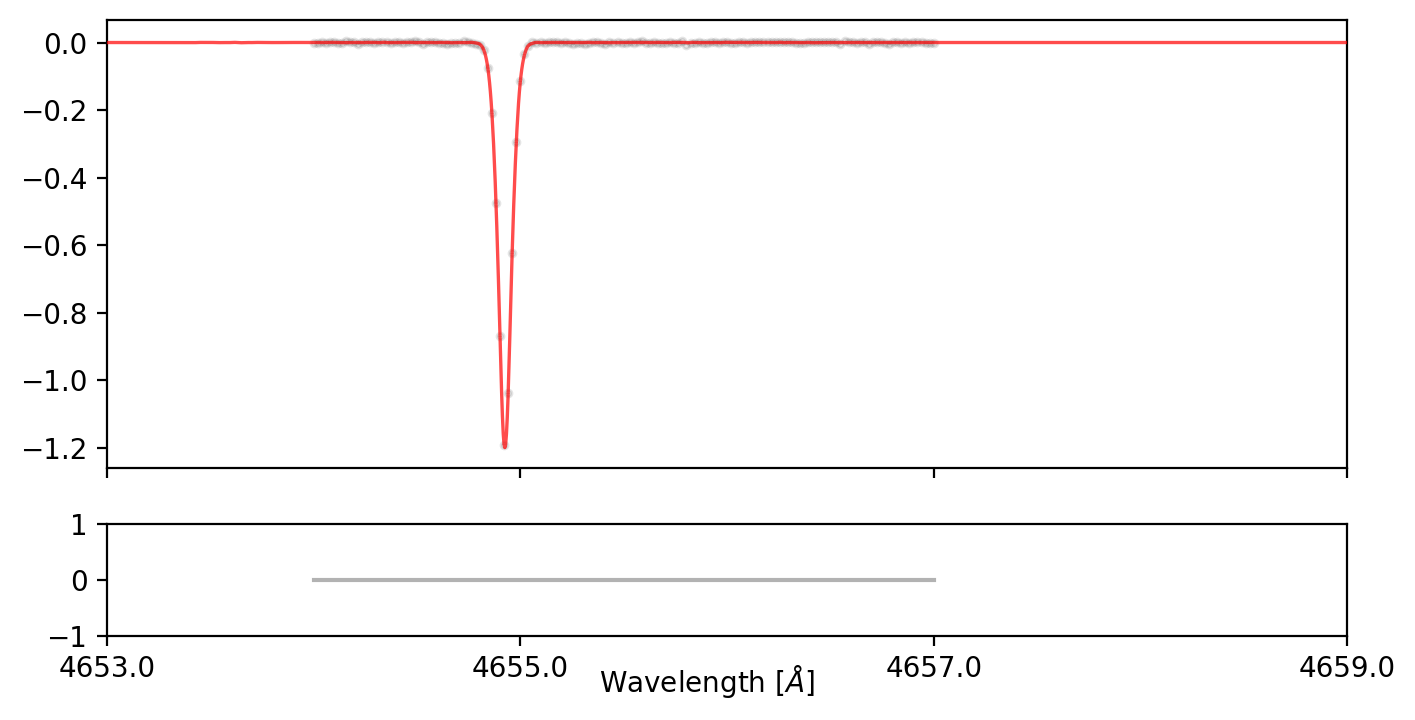

In [13]:
fig, axes = plt.subplots(2,1,figsize=(8,4),sharex='col',sharey='row',\
                             facecolor=(1, 1, 1),height_ratios=[4,1],dpi=200)


# plt_width = np.arange(-40,40,20) + 10
plt_epoch = 19

lrange = np.linspace(np.min(np.exp(dataset[plt_epoch].xs))-1,\
                     np.max(np.exp(dataset[plt_epoch].xs))+2,4)[:,None]

# lrange = l_plt*np.ones(len(rv_inds))[:,None] + np.arange(-2,2,2)[None,:] 


plt_name = "{}_spectra_l{}-{}.png".format('simple_fake',lrange.min(),lrange.max())
# axes[1,ii].text(dataset.metadata['order'][plt_epoches[0]])
axes[:] = make_subplot(axes[:],model,dataset,plt_epoch,cpus[0],lrange[:,0])
fig.text(0.5, 0.04, 'Wavelength [$\\AA$]', ha='center')
plt.show()

In [14]:
f_info = model.fischer_full(dataset, cpus[0])
reduce_index = [1]
reduce_info = model.reduce_fischer(f_info,reduce_index)
rv_err = jabble.quickplay.get_RV_sigmas(model, dataset, rv_ind = [0],device=cpus[0])


-CompositeModel--------------------------------------------------255
  0-ShiftingModel------------------------------------------------100
  1-FullCardinalSplineMixture------------------------------------155
[100, 155] 1
a 0 100 255 0 
n 100 255
(100, 155) (155, 100) (100, 100) (155, 155)
-CompositeModel--------------------------------------------------100
  0-ShiftingModel------------------------------------------------100
  1-FullCardinalSplineMixture--------------------------------------0


(100,) (100,) (100,)


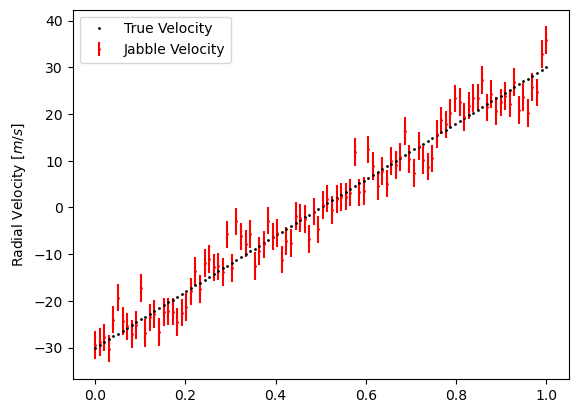

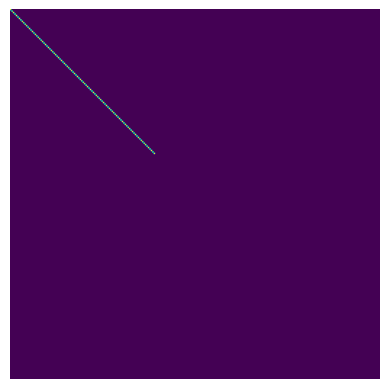

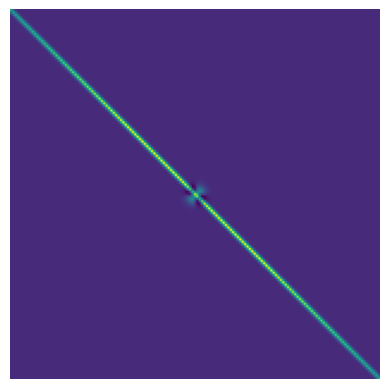

In [15]:
tspace = np.linspace(0,1,len(velocities))
print(tspace.shape,velocities.shape,model[0].p.shape)

temp_vel = (jabble.physics.velocities(model[0].p)*u.m/u.s - guess_vel).to(u.m/u.s).value
temp_vel -= temp_vel.mean()
plt.errorbar(tspace,temp_vel,yerr=rv_err,fmt='r.',label='Jabble Velocity',ms=2)
temp_vel = (velocities-guess_vel).to(u.m/u.s).value
temp_vel -= temp_vel.mean()
plt.plot(tspace,(velocities-guess_vel).to(u.m/u.s).value,'k.',label='True Velocity',ms=2)
plt.ylabel('Radial Velocity $[m/s]$')
plt.legend()
plt.show()

plt.imshow(f_info.transpose())
plt.axis('off')
plt.show()

plt.imshow(reduce_info.transpose())
plt.axis('off')
plt.show()

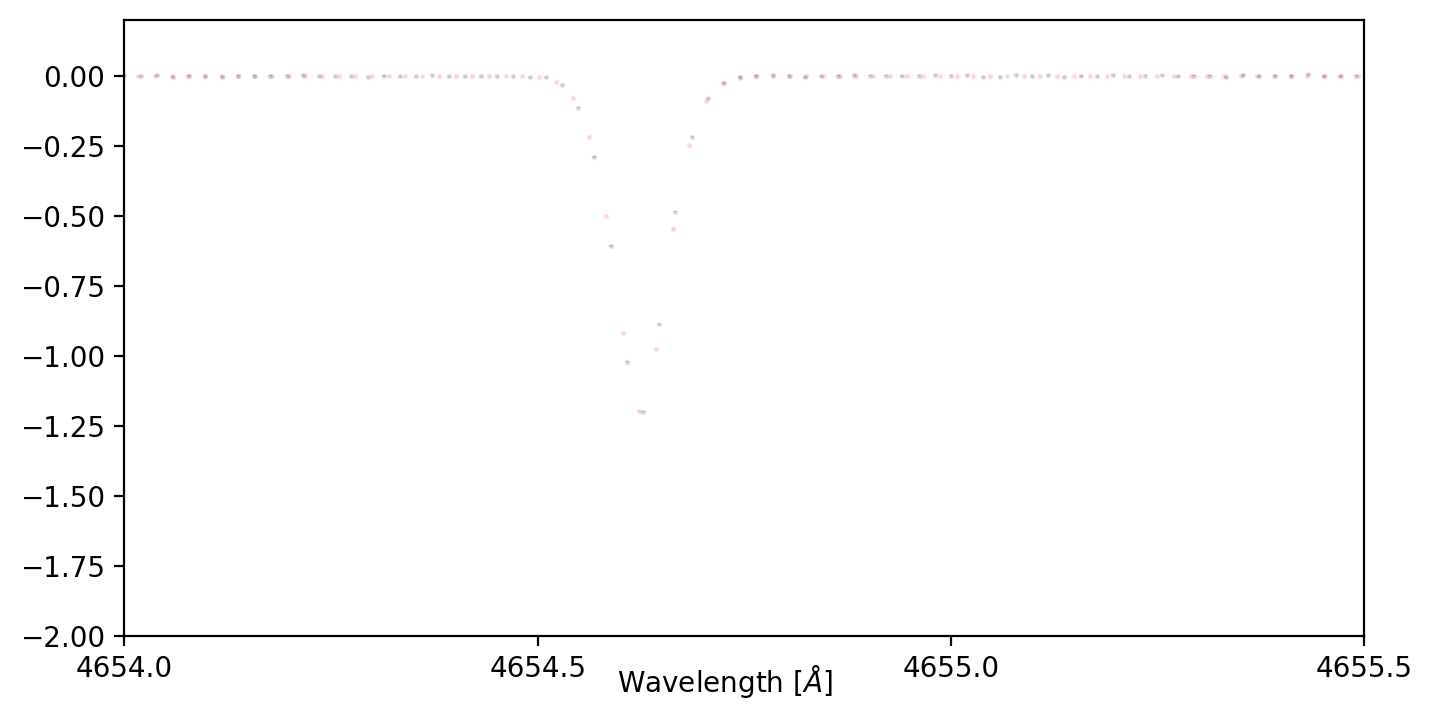

In [16]:
model.fix()

fig, axes = plt.subplots(1,1,figsize=(8,4),sharex='col',sharey='row',\
                             facecolor=(1, 1, 1),dpi=200)


# plt_width = np.arange(-40,40,20) + 10
plt_epoch = 10

lrange = np.linspace(4654,4655.5,4)

plt_epoch = 3

axes.errorbar(dataset[plt_epoch].xs,dataset[plt_epoch].ys,yerr=1/np.sqrt(dataset[plt_epoch].yivar),\
              fmt='.k',zorder=2,alpha=0.1,ms=2)

datablock, metablock = dataset.blockify(cpus[0])
metarow = jabble.loss.dict_ele(metablock, plt_epoch,cpus[0])

xp = model[0]([],np.log(np.linspace(4653,4655,100)),metarow)
model_info = model[1].transform_fisher(xp,xp,reduce_info)

axes.errorbar(xp,model([],xp,metarow),yerr=1/np.sqrt(np.diag(model_info)),\
              fmt='.r',zorder=2,alpha=0.1,ms=2)
axes.set_xticks(np.log(lrange))
axes.set_xticklabels(['{:0.1f}'.format(x) for x in lrange])
axes.set_xlim(np.log(lrange.min()),np.log(lrange.max()))
axes.set_ylim(-2,0.2)

fig.text(0.5, 0.04, 'Wavelength [$\\AA$]', ha='center')
plt_name = 'simple_fake_snr_e{}.png'.format(plt_epoch)
plt.savefig(os.path.join(out_dir,plt_name))
plt.show()

In [21]:
variance = np.linalg.inv(model_info)
temp_mask = (model_info < 1e10)
print(np.sum(temp_mask))
print(np.mean(np.diag(variance[temp_mask])))

9881
5.535661438190297e+18


In [18]:
np.mean(snr*np.sqrt(epoches))

5000.0

In [19]:
snr

500

0
10000


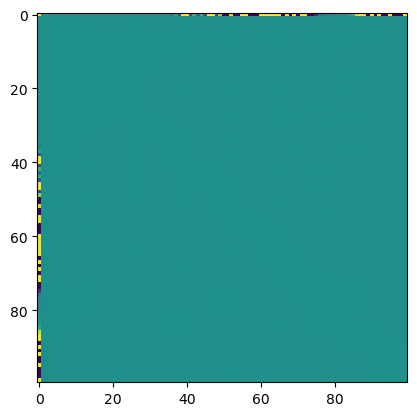

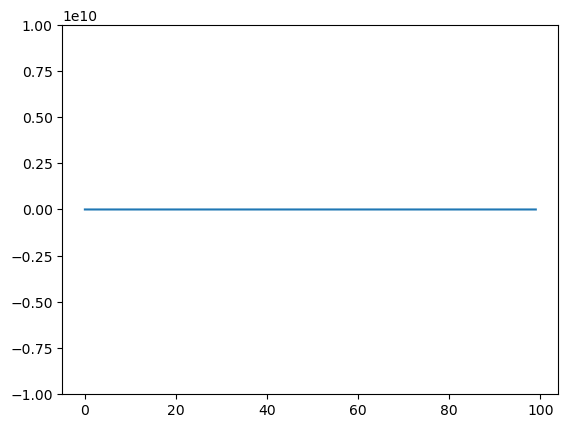

In [20]:
print(np.sum(np.diag(variance <= 0.0)))
print(np.product(model_info.shape))
plt.imshow(variance,vmin=-1e8,vmax=1e8)
plt.show()
plt.plot(np.sqrt(np.diag(variance)))
plt.ylim(-1e9,1e10)

plt.show()